# Лабораторная работа №1

### Загрузка необходимых библиотек и файла

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('datasets/train.csv')

## Предварительный анализ данных

### Основная информация

In [34]:
print(f"Размер датасета: {df.shape}")
print(f"\nТипы данных:")
print(df.dtypes.value_counts())
print(f"\nКоличество пропусков:")
print(df.isnull().sum().sort_values(ascending=False))
print(f"\nОсновные статистики:")
print(df.describe())
print(df.columns.tolist())
print("InterestRate:", f"min: {df['InterestRate'].min()}, max: {df['InterestRate'].max()}")
print("BaseInterestRate:", f"min: {df['BaseInterestRate'].min()}, max: {df['BaseInterestRate'].max()}")

Размер датасета: (11017, 35)

Типы данных:
float64    29
object      6
Name: count, dtype: int64

Количество пропусков:
MonthlyDebtPayments           1031
LoanAmount                    1031
CreditScore                   1031
BaseInterestRate              1031
NetWorth                      1031
TotalAssets                   1031
BankruptcyHistory             1031
LoanPurpose                   1031
CheckingAccountBalance        1031
ApplicationDate                530
Age                            530
AnnualIncome                   530
HomeOwnershipStatus            530
NumberOfCreditInquiries        530
NumberOfOpenCreditLines        530
CreditCardUtilizationRate      530
NumberOfDependents             530
MaritalStatus                  530
LoanDuration                   530
LengthOfCreditHistory          530
PaymentHistory                 530
PreviousLoanDefaults           530
DebtToIncomeRatio              530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
Savin

В RiskScore странные данные. Проведём анализ аномальных значений.

In [35]:
extreme_low = df[df['RiskScore'] <= -999999]
extreme_high = df[df['RiskScore'] >= 9999999]

print(f"Записей с экстремально низким RiskScore: {len(extreme_low)}")
print(f"Записей с экстремально высоким RiskScore: {len(extreme_high)}")
print(f"Всего аномальных записей: {len(extreme_low) + len(extreme_high)}")
print(f"Процент аномалий: {(len(extreme_low) + len(extreme_high))/len(df)*100:.2f}%")

Записей с экстремально низким RiskScore: 121
Записей с экстремально высоким RiskScore: 94
Всего аномальных записей: 215
Процент аномалий: 1.95%


In [36]:
df_clean = df[(df['RiskScore'] > -999999) & (df['RiskScore'] < 9999999)]
clean_risk = df_clean['RiskScore']

print(f"После очистки:")
print(f"Минимальный RiskScore: {clean_risk.min()}")
print(f"Максимальный RiskScore: {clean_risk.max()}")
print(f"Средний RiskScore: {clean_risk.mean():.2f}")
print(f"Медианный RiskScore: {clean_risk.median():.2f}")


После очистки:
Минимальный RiskScore: 14.841417296887238
Максимальный RiskScore: 97.59724939432462
Средний RiskScore: 48.36
Медианный RiskScore: 44.20


5% перцентиль: 26.69
10% перцентиль: 28.61
25% перцентиль: 32.72
50% перцентиль: 44.20
75% перцентиль: 65.12
90% перцентиль: 72.23
95% перцентиль: 75.75


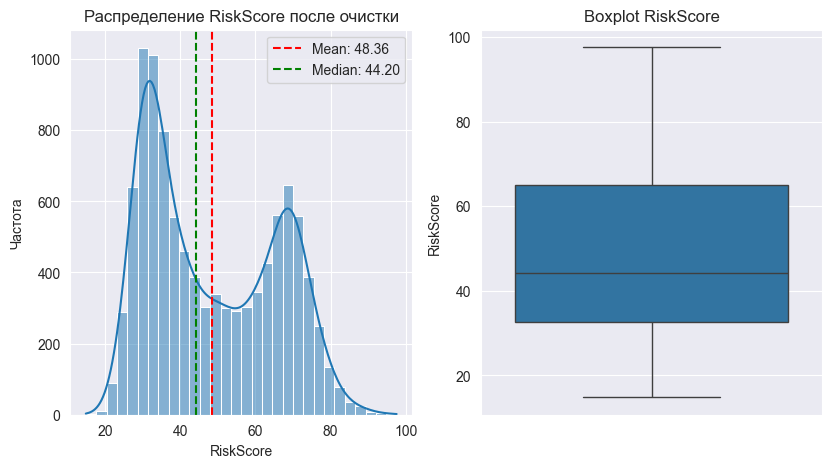

In [37]:
plt.figure(figsize=(15, 5))

# 1. Гистограмма с плотностью
plt.subplot(1, 3, 1)
sns.histplot(clean_risk, bins=30, kde=True)
plt.axvline(clean_risk.mean(), color='red', linestyle='--', label=f'Mean: {clean_risk.mean():.2f}')
plt.axvline(clean_risk.median(), color='green', linestyle='--', label=f'Median: {clean_risk.median():.2f}')
plt.title('Распределение RiskScore после очистки')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.legend()

# 2. Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=clean_risk)
plt.title('Boxplot RiskScore')
plt.ylabel('RiskScore')


# Процентили
percentiles = [5, 10, 25, 50, 75, 90, 95]
for p in percentiles:
    print(f"{p}% перцентиль: {np.percentile(clean_risk, p):.2f}")

In [38]:
print(df_clean["EducationLevel"].unique())

['Associate' 'High School' 'Bachelor' 'Master' 'Doctorate']


                 mean  median    std  count
EducationLevel                             
Associate       48.28   44.19  17.25   2019
Bachelor        48.09   43.35  17.24   3026
Doctorate       46.11   37.90  17.96    339
High School     49.03   46.36  17.05   4150
Master          46.90   39.67  17.78    738


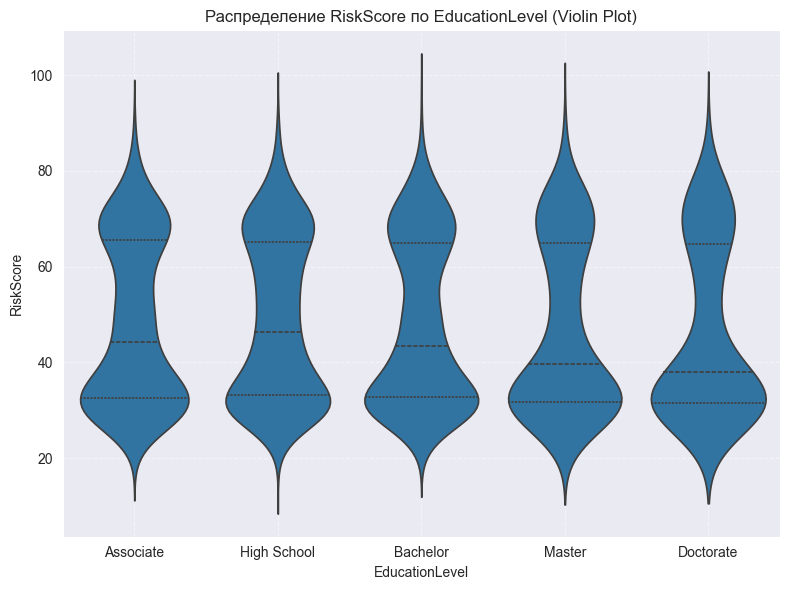

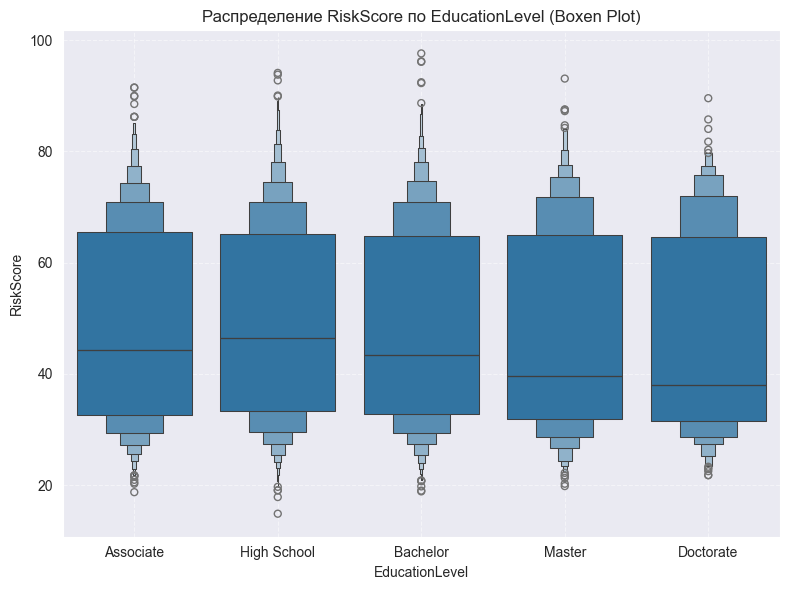

In [39]:
columns = [
    'ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration',
    'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments',
    'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries',
    'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults',
    'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance',
    'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'NetWorth',
    'BaseInterestRate', 'EmploymentStatus', 'EducationLevel', 'JobTenure',
    'TotalDebtToIncomeRatio', 'InterestRate', 'MonthlyLoanPayment', 'UtilityBillsPaymentHistory',
    'RiskScore'
]
cat_to_analiz = columns[26]

stats = df_clean.groupby(cat_to_analiz)['RiskScore'].agg(['mean', 'median', 'std', 'count']).round(2)
print(stats)

# Построение графика
plt.figure(figsize=(8, 6))
sns.violinplot(data=df_clean, x=cat_to_analiz, y='RiskScore', inner='quartile')
plt.title(f'Распределение RiskScore по {cat_to_analiz} (Violin Plot)')
plt.xlabel(cat_to_analiz)
plt.ylabel('RiskScore')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.boxenplot(data=df_clean, x=cat_to_analiz, y='RiskScore')
plt.title(f'Распределение RiskScore по {cat_to_analiz} (Boxen Plot)')
plt.xlabel(cat_to_analiz)
plt.ylabel('RiskScore')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [40]:
## Заполнение пропусков

for column in df_clean.columns:
    if df_clean[column].dtype in ['int64', 'float64']:
        df_clean[column] = df_clean[column].fillna(df_clean[column].median())
    elif df_clean[column].dtype == 'object':
        df_clean[column] = df_clean[column].fillna(df_clean[column].mode()[0] if not df_clean[column].mode().empty else '')

Анализ остальных параметров

In [41]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

if 'RiskScore' in numeric_cols:
    numeric_cols.remove('RiskScore')

summary_stats = df_clean[numeric_cols].describe().T
summary_stats['IQR'] = summary_stats['75%'] - summary_stats['25%']
summary_stats['Range'] = summary_stats['max'] - summary_stats['min']
summary_stats['Coef_Var'] = (summary_stats['std'] / summary_stats['mean'] * 100)

print("Признаки с наибольшей вариативностью:")
print(summary_stats.sort_values('Coef_Var', ascending=False).head(10))

Признаки с наибольшей вариативностью:
                           count           mean            std          min  \
BankruptcyHistory        10272.0       0.050136       0.218237     0.000000   
NetWorth                 10272.0  147656.007399  451168.719042  1004.000000   
PreviousLoanDefaults     10272.0       0.096963       0.295921     0.000000   
TotalLiabilities         10272.0   68915.008372  204540.543080    78.000000   
TotalAssets              10272.0  176624.918614  456160.792394   892.000000   
TotalDebtToIncomeRatio   10272.0       0.518555       0.898450     0.006064   
CheckingAccountBalance   10272.0    1946.905471    2996.443557    16.000000   
SavingsAccountBalance    10272.0    5496.205802    8458.073352    31.000000   
MonthlyLoanPayment       10272.0    1078.767925    1351.902026    30.008506   
NumberOfCreditInquiries  10272.0       0.977998       0.988643     0.000000   

                                  25%           50%            75%  \
BankruptcyHistory     

BankruptcyHistory и PreviousLoanDefaults бинарные признаки, и их высокий коэффициент вариации объясняется не выбросами, а несбалансированностью классов. Это нормально для таких признаков.

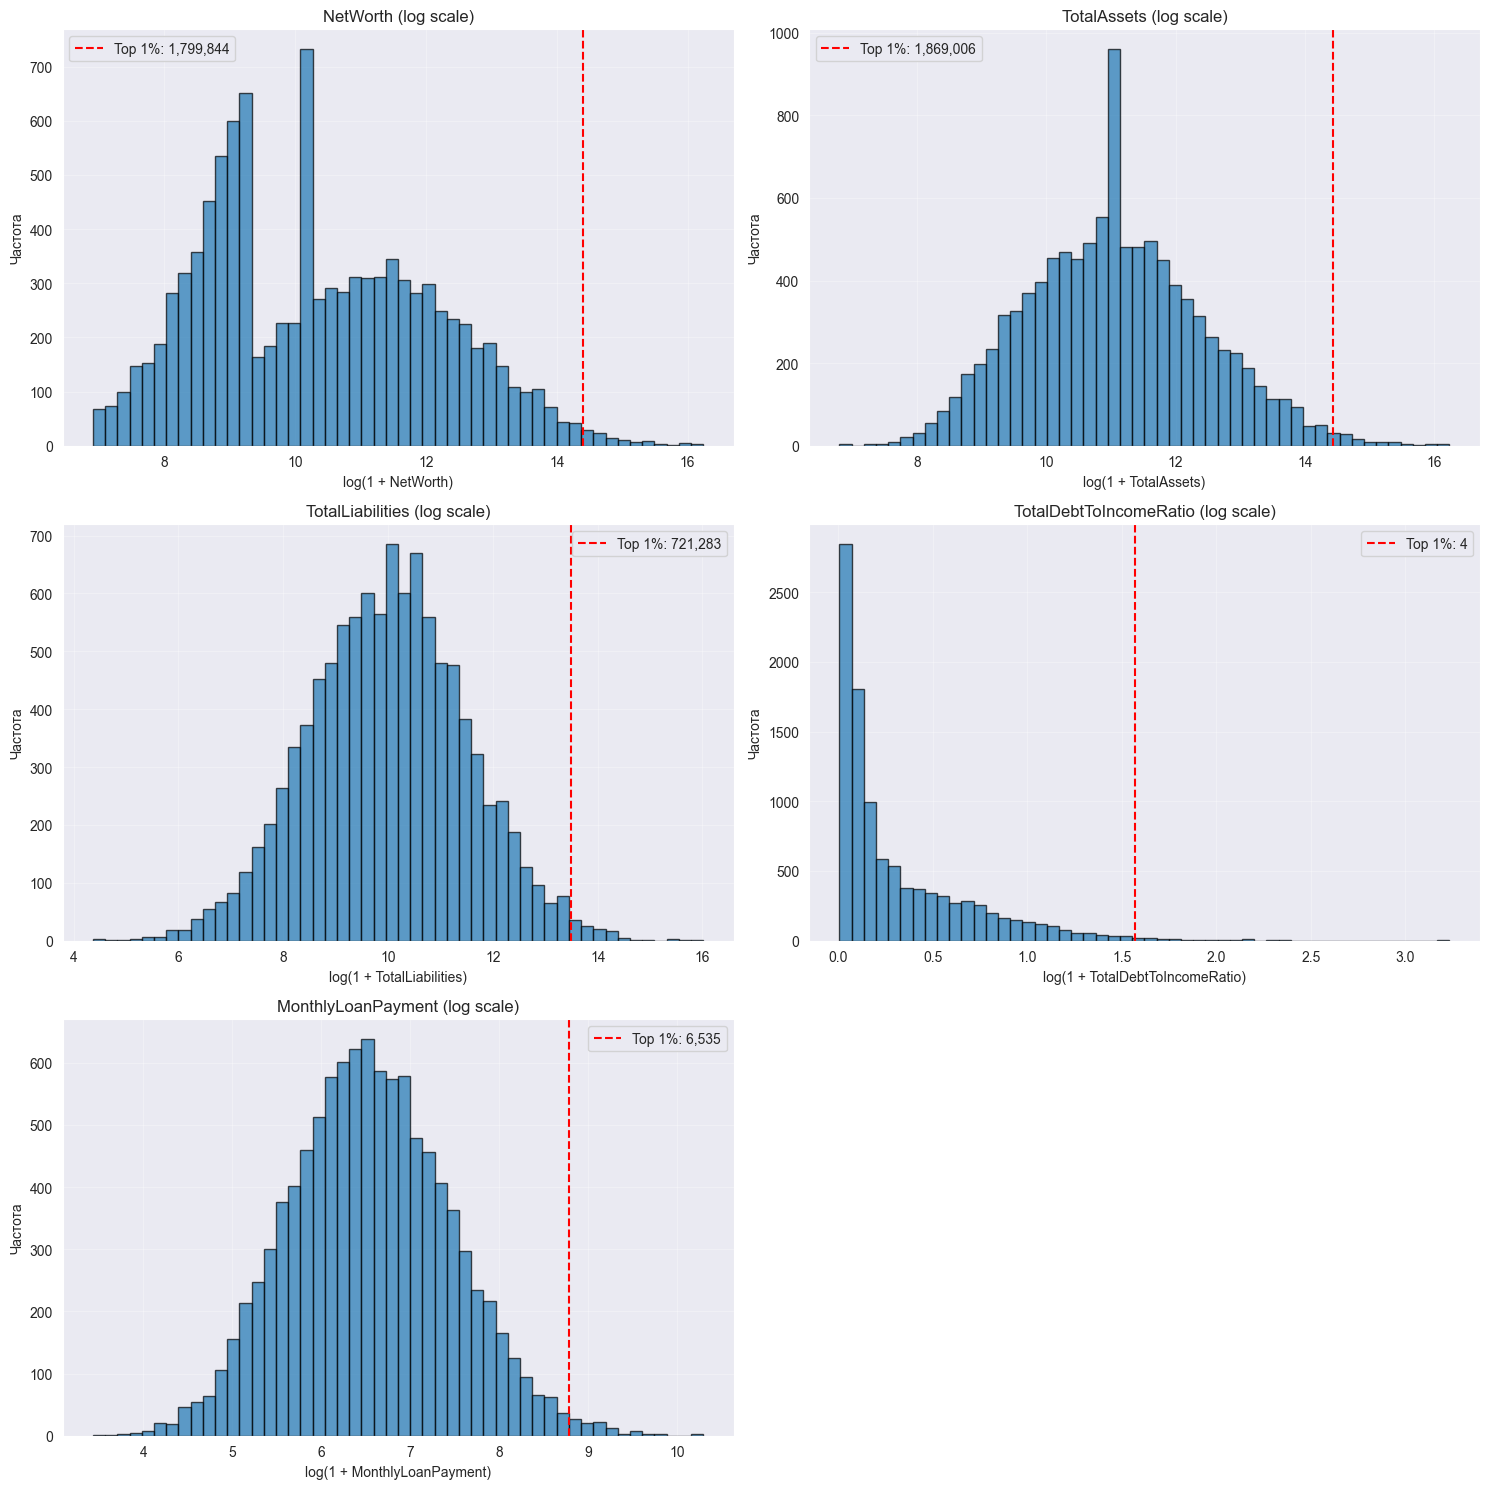

In [42]:
extreme_features = ['NetWorth', 'TotalAssets', 'TotalLiabilities',
                   'TotalDebtToIncomeRatio', 'MonthlyLoanPayment']

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, feature in enumerate(extreme_features):
    if i < len(extreme_features):
        ax = axes[i]
        data = df_clean[feature]

        # Для положительных значений используем логарифм
        if data.min() > 0:
            log_data = np.log1p(data)
            ax.hist(log_data, bins=50, alpha=0.7, edgecolor='black')
            ax.set_title(f'{feature} (log scale)')
            ax.set_xlabel(f'log(1 + {feature})')

            threshold = np.percentile(data, 99)
            log_threshold = np.log1p(threshold)
            ax.axvline(log_threshold, color='red', linestyle='--',
                      label=f'Top 1%: {threshold:,.0f}')
        else:
            ax.hist(data, bins=50, alpha=0.7, edgecolor='black')
            ax.set_title(f'{feature}')
            ax.set_xlabel(feature)

            threshold = np.percentile(data, 99)
            ax.axvline(threshold, color='red', linestyle='--',
                      label=f'Top 1%: {threshold:.2f}')

        ax.set_ylabel('Частота')
        ax.legend()
        ax.grid(True, alpha=0.3)

if len(extreme_features) < 6:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

Обработка даты

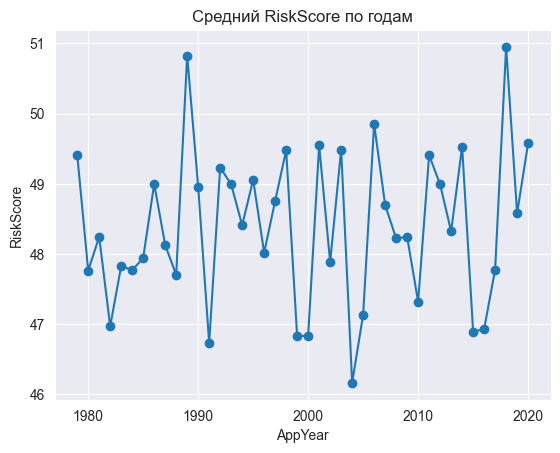

In [43]:
df_clean['ApplicationDate'] = pd.to_datetime(df_clean['ApplicationDate'])

df_clean['AppYear'] = df_clean['ApplicationDate'].dt.year
df_clean['AppMonth'] = df_clean['ApplicationDate'].dt.month


df_clean.groupby('AppYear')['RiskScore'].mean().plot(kind='line', marker='o')
plt.title('Средний RiskScore по годам')
plt.ylabel('RiskScore')
plt.grid(True)



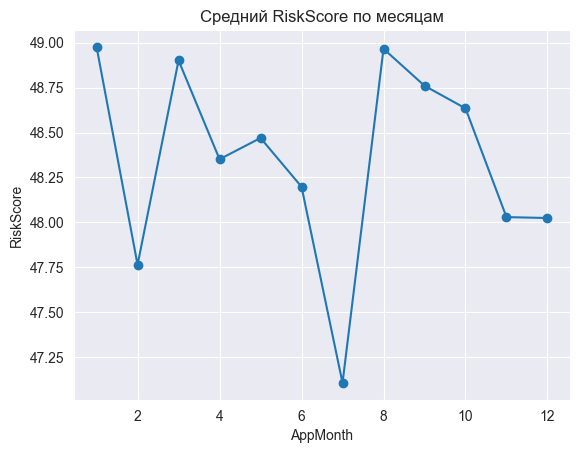

In [44]:
df_clean.groupby('AppMonth')['RiskScore'].mean().plot(kind='line', marker='o')
plt.title('Средний RiskScore по месяцам')
plt.ylabel('RiskScore')
plt.grid(True)

Используются не все столбцы, так как некоторые из них ни с одним другим не коррелируется

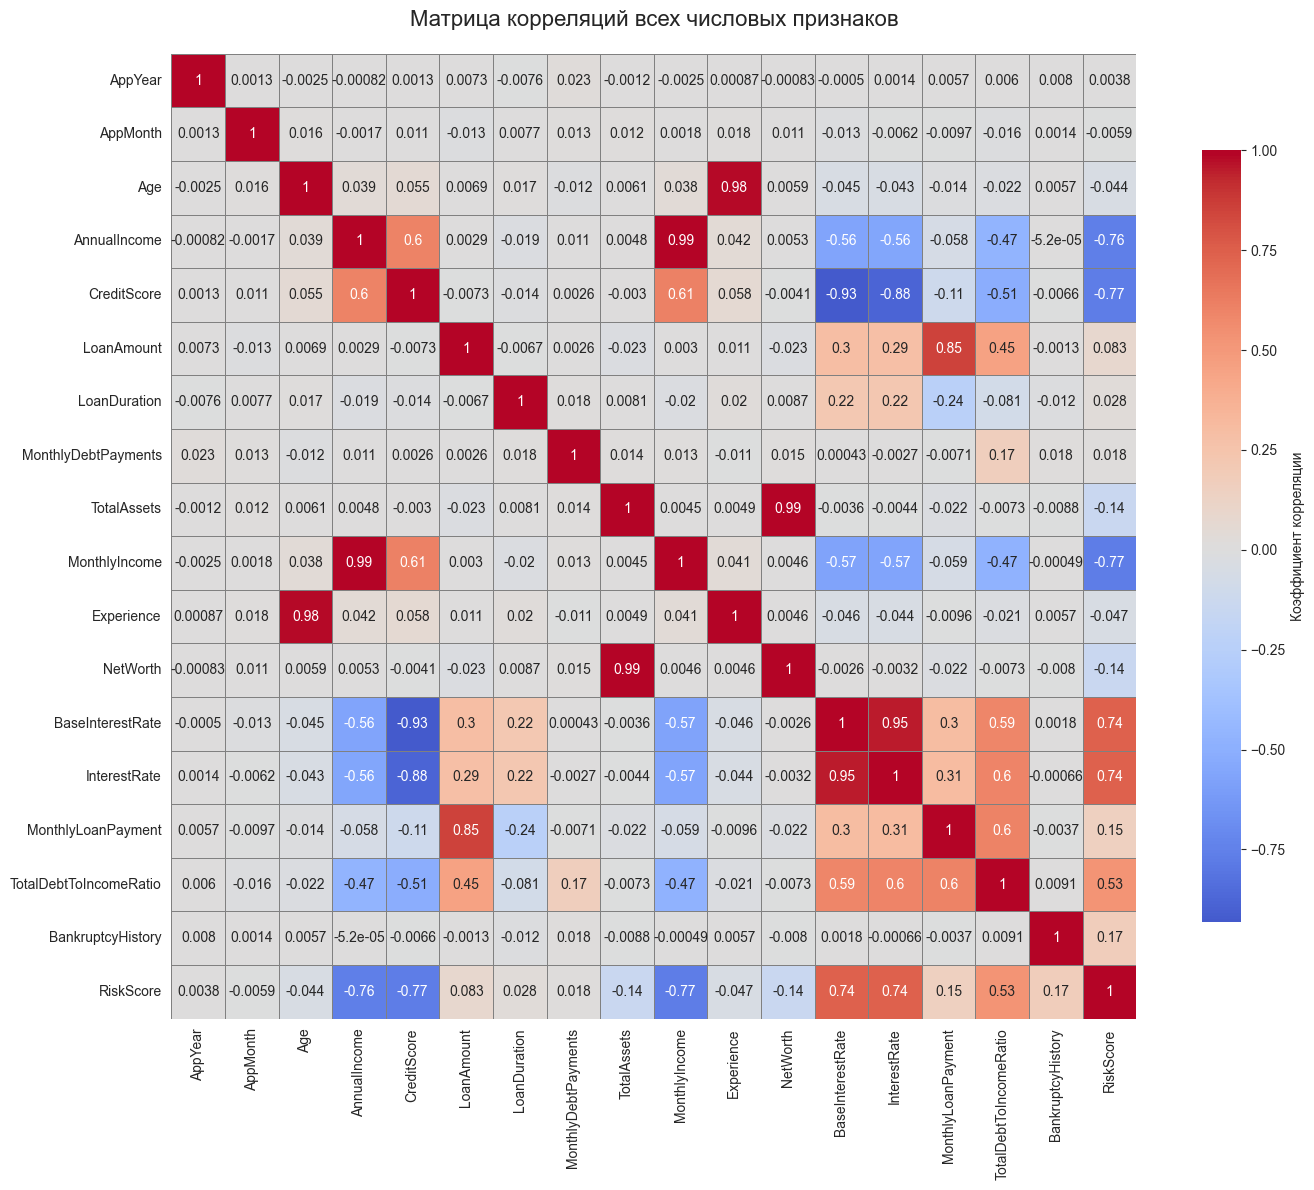

In [45]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
selected_features = ['AppYear', 'AppMonth',
                     'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration',
                     'MonthlyDebtPayments', 'TotalAssets', 'MonthlyIncome', 'Experience',
                     'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment',
                     'TotalDebtToIncomeRatio', 'BankruptcyHistory', 'RiskScore']
correlation_matrix = df_clean[selected_features].corr()


plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8, 'label': 'Коэффициент корреляции'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Матрица корреляций всех числовых признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


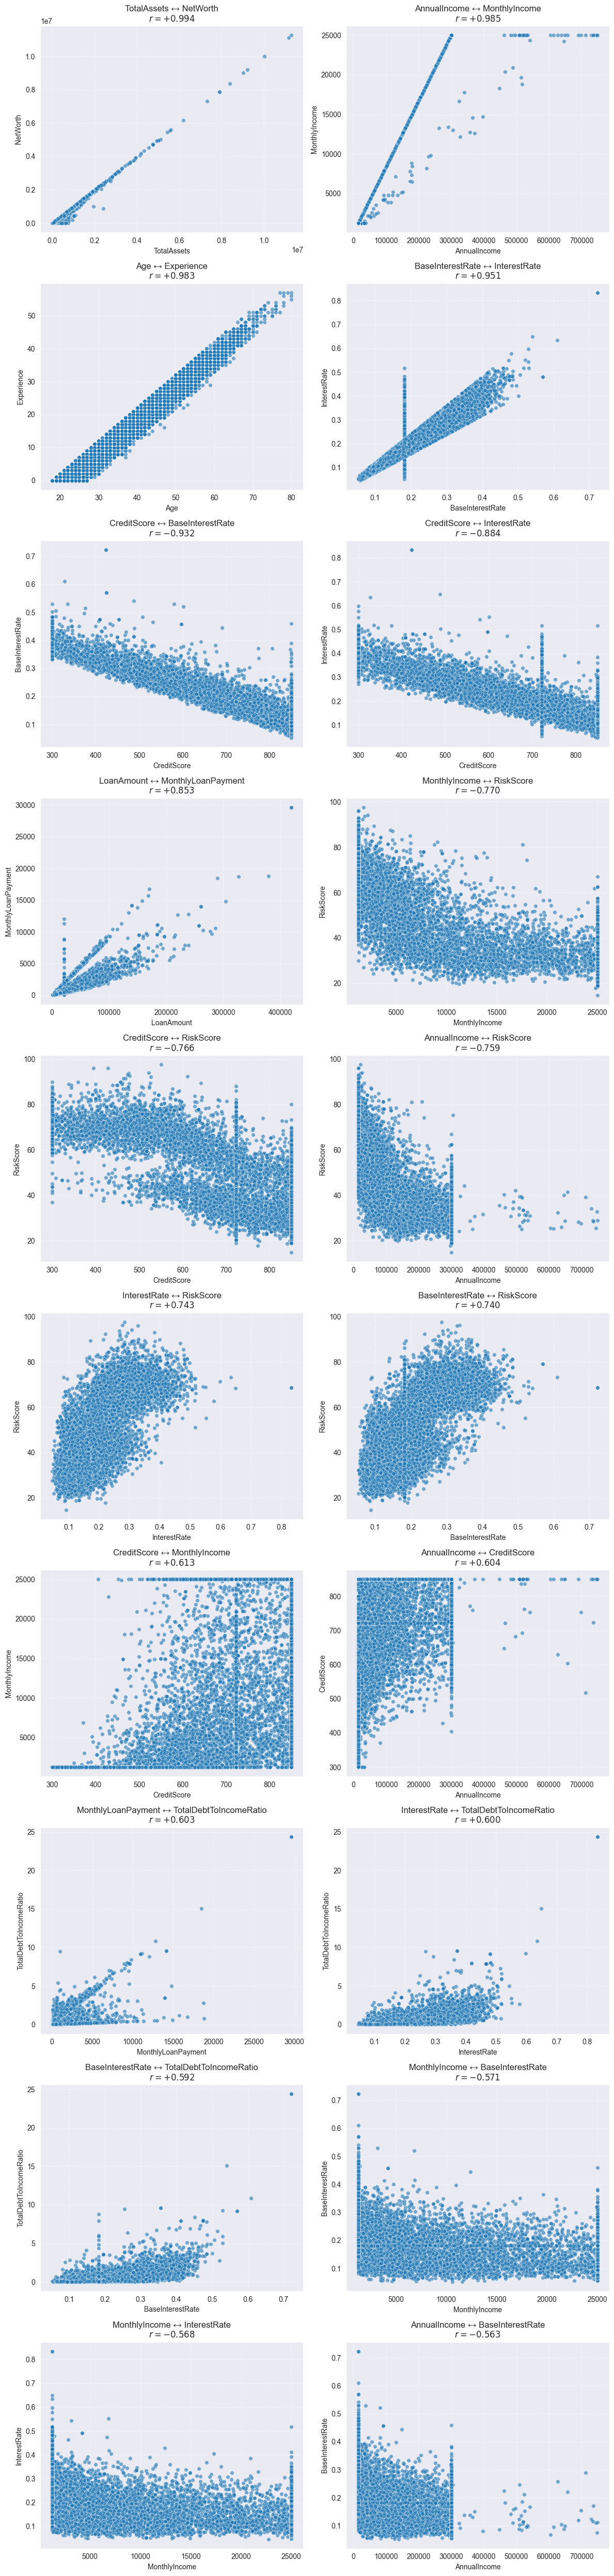

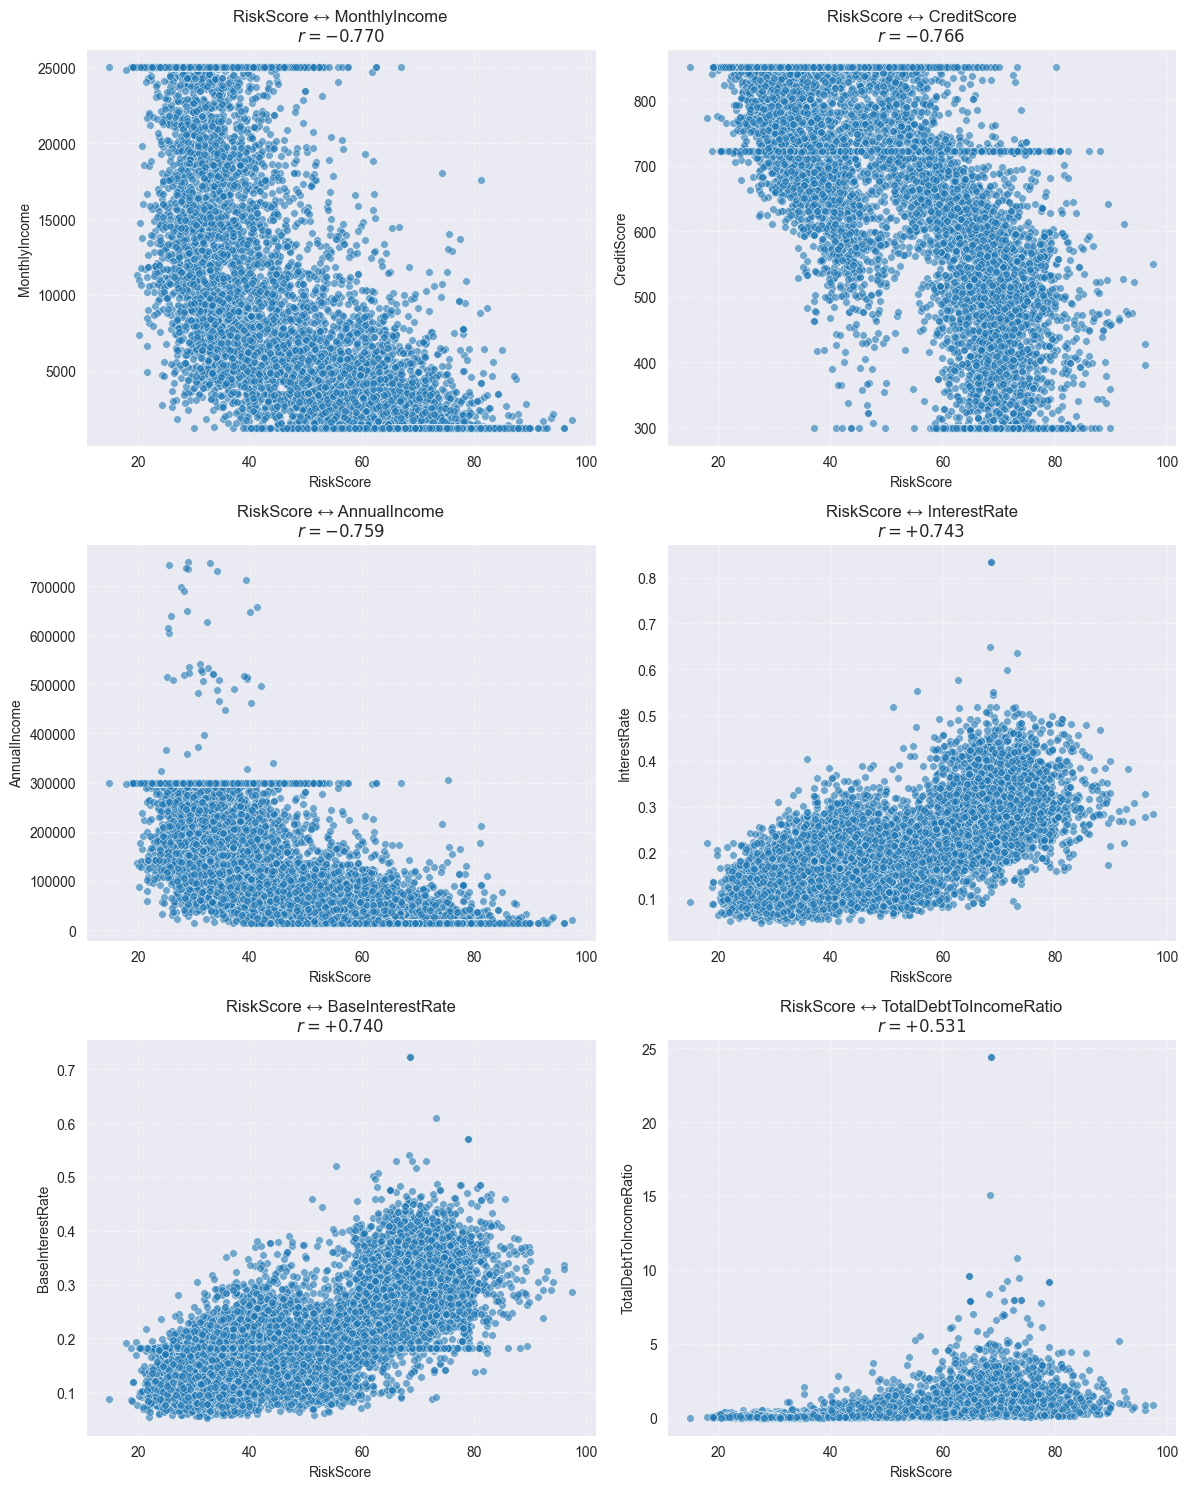

In [46]:
def plot_significant_correlations(df_in, target=None, threshold=0.5, max_plots=20, figsize_per_plot=(6, 5)):
    numeric_df = df_in.select_dtypes(include=[np.number])
    if target and target not in numeric_df.columns:
        raise ValueError(f"Целевая переменная '{target}' отсутствует или нечисловая.")

    corr = numeric_df.corr()
    pairs = []

    if target:
        for col in numeric_df.columns:
            if col != target:
                r = corr.loc[target, col]
                if abs(r) >= threshold:
                    pairs.append((target, col, r))
    else:
        cols = numeric_df.columns
        for i in range(len(cols)):
            for j in range(i + 1, len(cols)):
                r = corr.iloc[i, j]
                if abs(r) >= threshold:
                    pairs.append((cols[i], cols[j], r))
    pairs = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)[:max_plots]

    if not pairs:
        print(f"Нет пар с |корреляцией| ≥ {threshold}")
        return

    n = len(pairs)
    cols = 2
    rows = (n + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_plot[0]*cols, figsize_per_plot[1]*rows))
    axes = axes.flatten() if n > 1 else [axes]

    for idx, (x, y, r) in enumerate(pairs):
        ax = axes[idx]
        sns.scatterplot(data=numeric_df, x=x, y=y, ax=ax, alpha=0.6, s=30)
        sign = '+' if r > 0 else '-'
        ax.set_title(f'{x} ↔ {y}\n$r = {sign}{abs(r):.3f}$', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)

    for idx in range(n, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()


df_numeric = df_clean[numeric_cols]

plot_significant_correlations(df_numeric, threshold=0.5)

plot_significant_correlations(df_numeric, target='RiskScore', threshold=0.3)

Вывод: RiskScore естественным образом разделяет клиентов на два сегмента: низкорисковых и высокорисковых. Финансовые показатели подтверждают гипотезу о двух сегментах клиентов. Это важно для понимания структуры данных и может помочь в сегментации клиентов при построении модели. Данные содержат сильные линейные зависимости, которые логично объясняются бизнес-правилами кредитования. Это подтверждает, что линейная регрессия будет эффективной моделью для предсказания RiskScore.

## Нормализация данных

In [47]:
from typing import List, Optional


class CreditDataPreprocessor:
    def __init__(self):
        self.categorical_features = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
        self.ordinal_features = {
            'EducationLevel': ['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate'],
            'EmploymentStatus': ['Unemployed', 'Self-Employed', 'Employed']
        }
        self.binary_features = ['BankruptcyHistory', 'PreviousLoanDefaults']
        self.min_max_features = [
            'AppMonth', 'Age', 'LoanDuration', 'JobTenure',
            'NumberOfDependents', 'CreditScore', 'Experience'
        ]
        self.to_log1p_features = [
            'LoanAmount', 'TotalAssets', 'TotalLiabilities',
            'SavingsAccountBalance', 'CheckingAccountBalance',
            'MonthlyDebtPayments', 'MonthlyLoanPayment',
            'AnnualIncome', 'MonthlyIncome'
        ]
        self.z_score_after_log = [
            'LoanAmount', 'TotalAssets', 'TotalLiabilities',
            'SavingsAccountBalance', 'CheckingAccountBalance',
            'MonthlyDebtPayments', 'MonthlyLoanPayment',
            'AnnualIncome', 'MonthlyIncome'
        ]
        self.z_score_direct = [
            'NetWorth', 'DebtToIncomeRatio', 'TotalDebtToIncomeRatio',
            'PaymentHistory', 'UtilityBillsPaymentHistory',
            'LengthOfCreditHistory', 'AppYear',
            'BaseInterestRate', 'InterestRate'
        ]
        self.to_drop = ['Experience', 'MonthlyIncome', 'NetWorth', 'TotalDebtToIncomeRatio']

        # Внутренние состояния (заполняются в .fit())
        self.scaler_minmax = {}
        self.scaler_zscore = {}
        self.fill_values = {}  # {'col': fill_value}
        self.fill_categories = {}  # {'col': 'Unknown'}
        self._is_fitted = False
        self.column = []

    def _encode_categoricals(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        return pd.get_dummies(
            dataframe,
            columns=self.categorical_features,
            drop_first=True,
            dtype=int
        )

    def _encode_ordinals(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe = dataframe.copy()
        for col, order in self.ordinal_features.items():
            if col in dataframe.columns:
                mapping = {v: i for i, v in enumerate(order)}
                dataframe[col] = dataframe[col].map(mapping).fillna(-1).astype(int)
        return dataframe

    def _encode_binaries(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe = dataframe.copy()
        for col in self.binary_features:
            if col in dataframe.columns:
                dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce').fillna(0).astype(int)
        return dataframe

    def _handle_missing(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe = dataframe.copy()
        num_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()
        for col in num_cols:
            if col in dataframe.columns:
                if self._is_fitted:
                    # transform: используем сохранённую медиану
                    fill_val = self.fill_values.get(col)
                    if fill_val is not None:
                        dataframe[col] = dataframe[col].fillna(fill_val)
                else:
                    # fit: вычисляем и сохраняем
                    median_val = dataframe[col].median()
                    self.fill_values[col] = median_val
                    dataframe[col] = dataframe[col].fillna(median_val)

        # 2. Категориальные → "Unknown"
        cat_cols = self.categorical_features + list(self.ordinal_features.keys())
        for col in cat_cols:
            if col in dataframe.columns:
                if self._is_fitted:
                    fill_cat = self.fill_categories.get(col)
                    dataframe[col] = dataframe[col].fillna(fill_cat)
                else:
                    # В fit всегда заполняем "Unknown"
                    mode_val = dataframe[col].mode()
                    self.fill_categories[col] = mode_val
                    dataframe[col] = dataframe[col].fillna(mode_val)

        # 3. Бинарные → 0 (уже делается в _encode_binaries через .fillna(0), но дублируем для надёжности)
        for col in self.binary_features:
            if col in dataframe.columns:
                dataframe[col] = dataframe[col].fillna(0)

        return dataframe

    def _safe_log1p(self, series: pd.Series) -> pd.Series:
        series = pd.to_numeric(series, errors='coerce').fillna(0.0)
        series = series.clip(lower=-1 + 1e-9)
        return series.map(lambda x: np.log1p(x))

    def fit(self, X_input: pd.DataFrame, y: Optional[pd.Series] = None) -> 'CreditDataPreprocessor':
        X = X_input.copy()

        X['ApplicationDate'] = pd.to_datetime(X['ApplicationDate'])
        X['AppYear'] = X['ApplicationDate'].dt.year
        X['AppMonth'] = X['ApplicationDate'].dt.month
        X = X.drop('ApplicationDate', axis=1)

        X = X.drop(self.to_drop, axis=1)

        X = self._handle_missing(X)

        X = self._encode_categoricals(X)
        X = self._encode_ordinals(X)
        X = self._encode_binaries(X)

        for col in self.to_log1p_features:
            if col in X.columns:
                X[col] = self._safe_log1p(X[col])

        for col in self.min_max_features:
            if col in X.columns:
                min_val = X[col].min()
                max_val = X[col].max()
                scale = max(max_val - min_val, 1e-8)
                self.scaler_minmax[col] = (min_val, scale)

        for col in self.z_score_after_log + self.z_score_direct:
            if col in X.columns:
                mean = X[col].mean()
                std = X[col].std()
                std = max(std, 1e-8)
                self.scaler_zscore[col] = (mean, std)

        self._is_fitted = True
        self.column = X.columns
        return self

    def transform(self, X_input: pd.DataFrame) -> pd.DataFrame:
        if not self._is_fitted:
            raise ValueError("CreditDataPreprocessor is not fitted yet. Call .fit() first.")

        X = X_input.copy()

        X['ApplicationDate'] = pd.to_datetime(X['ApplicationDate'])
        X['AppYear'] = X['ApplicationDate'].dt.year
        X['AppMonth'] = X['ApplicationDate'].dt.month
        X = X.drop('ApplicationDate', axis=1)

        X = X.drop(self.to_drop, axis=1)

        X = self._handle_missing(X)


        X = self._encode_categoricals(X)
        X = self._encode_ordinals(X)
        X = self._encode_binaries(X)

        for col in self.to_log1p_features:
            if col in X.columns:
                X[col] = self._safe_log1p(X[col])

        for col in self.min_max_features:
            if col in X.columns and col in self.scaler_minmax:
                min_val, scale = self.scaler_minmax[col]
                X[col] = (X[col] - min_val) / scale

        for col in self.z_score_after_log + self.z_score_direct:
            if col in X.columns and col in self.scaler_zscore:
                mean, std = self.scaler_zscore[col]
                X[col] = (X[col] - mean) / std

        return X

    def fit_transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        return self.fit(X, y).transform(X)

    def get_feature_names_out(self) -> List[str]:
        if not self._is_fitted:
            raise ValueError("Preprocessor is not fitted yet.")
        return self.column



## Реализация метрик

In [48]:
import numpy as np
from typing import Optional


def mse(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        sample_weight: Optional[np.ndarray] = None
) -> float:
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")
    errors = y_true - y_pred
    squared_errors = np.square(errors)

    if sample_weight is not None:
        sample_weight = np.asarray(sample_weight, dtype=np.float64)
        if sample_weight.shape != y_true.shape:
            raise ValueError("sample_weight must have the same shape as y_true")
        return np.sum(squared_errors * sample_weight) / np.sum(sample_weight)

    return np.mean(squared_errors)


def mae(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        sample_weight: Optional[np.ndarray] = None
) -> float:
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    abs_errors = np.abs(y_true - y_pred)

    if sample_weight is not None:
        sample_weight = np.asarray(sample_weight, dtype=np.float64)
        return np.sum(abs_errors * sample_weight) / np.sum(sample_weight)

    return np.mean(abs_errors)


def r2(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        sample_weight: Optional[np.ndarray] = None
) -> float:
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    if len(y_true) < 2:
        raise ValueError("R² score is not well-defined with less than two samples")

    if sample_weight is not None:
        sample_weight = np.asarray(sample_weight, dtype=np.float64)
        weighted_mean_true = np.average(y_true, weights=sample_weight)
        ss_res = np.sum(sample_weight * (y_true - y_pred) ** 2)
        ss_tot = np.sum(sample_weight * (y_true - weighted_mean_true) ** 2)
    else:
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)

    if ss_tot == 0:
        return 1.0 if ss_res == 0 else 0.0
    return 1.0 - (ss_res / ss_tot)


def mape(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        sample_weight: Optional[np.ndarray] = None,
        epsilon: float = 1e-8  # для защиты от деления на 0
) -> float:
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    y_true_safe = np.where(np.abs(y_true) < epsilon, epsilon * np.sign(y_true + epsilon), y_true)

    ape = np.abs((y_true - y_pred) / y_true_safe)

    if sample_weight is not None:
        sample_weight = np.asarray(sample_weight, dtype=np.float64)
        return np.sum(ape * sample_weight) / np.sum(sample_weight)

    return np.mean(ape)

### Сравнение с sklearn

In [49]:
from sklearn.metrics import (
    mean_squared_error as mse_sk,
    mean_absolute_error as mae_sk,
    r2_score as r2_sk,
    mean_absolute_percentage_error as mape_sk
)

np.random.seed(42)
n = 1000

y_true = np.random.uniform(10, 100, size=n)
y_pred = y_true + np.random.normal(0, 5, size=n)

sample_weight = np.random.rand(n)

print("=== MSE ===")
print("Кастомный:", mse(y_true, y_pred))
print("sklearn  :", mse_sk(y_true, y_pred))
print("Ошибка   :", abs(mse(y_true, y_pred) - mse_sk(y_true, y_pred)))

print("\n=== MAE ===")
print("Кастомный:", mae(y_true, y_pred))
print("sklearn  :", mae_sk(y_true, y_pred))
print("Ошибка   :", abs(mae(y_true, y_pred) - mae_sk(y_true, y_pred)))

print("\n=== R² ===")
print("Кастомный:", r2(y_true, y_pred))
print("sklearn  :", r2_sk(y_true, y_pred))
print("Ошибка   :", abs(r2(y_true, y_pred) - r2_sk(y_true, y_pred)))

print("\n=== MAPE (без весов) ===")
y_true_nozero = np.where(np.abs(y_true) < 1e-6, 1e-6, y_true)
print("Кастомный:", mape(y_true_nozero, y_pred))
print("sklearn  :", mape_sk(y_true_nozero, y_pred))
print("Ошибка   :", abs(mape(y_true_nozero, y_pred) - mape_sk(y_true_nozero, y_pred)))

print("\n=== MAPE (с весами) ===")
mape_weighted = mape(y_true_nozero, y_pred, sample_weight=sample_weight)
print("Кастомный (с весами):", mape_weighted)
print("sklearn: не поддерживает sample_weight для MAPE")

print("\n=== Взвешенный MSE ===")
print("Кастомный:", mse(y_true, y_pred, sample_weight=sample_weight))
print("sklearn  :", mse_sk(y_true, y_pred, sample_weight=sample_weight))
print("Ошибка   :", abs(mse(y_true, y_pred, sample_weight=sample_weight) - mse_sk(y_true, y_pred, sample_weight=sample_weight)))

print("\n=== Взвешенный MAE ===")
print("Кастомный:", mae(y_true, y_pred, sample_weight=sample_weight))
print("sklearn  :", mae_sk(y_true, y_pred, sample_weight=sample_weight))
print("Ошибка   :", abs(mae(y_true, y_pred, sample_weight=sample_weight) - mae_sk(y_true, y_pred, sample_weight=sample_weight)))

print("\n=== Взвешенный R² ===")
print("Кастомный:", r2(y_true, y_pred, sample_weight=sample_weight))
print("sklearn  :", r2_sk(y_true, y_pred, sample_weight=sample_weight))
print("Ошибка   :", abs(r2(y_true, y_pred, sample_weight=sample_weight) - r2_sk(y_true, y_pred, sample_weight=sample_weight)))

=== MSE ===
Кастомный: 24.66977338137782
sklearn  : 24.66977338137782
Ошибка   : 0.0

=== MAE ===
Кастомный: 3.949939993406326
sklearn  : 3.949939993406326
Ошибка   : 0.0

=== R² ===
Кастомный: 0.9642776150195663
sklearn  : 0.9642776150195663
Ошибка   : 0.0

=== MAPE (без весов) ===
Кастомный: 0.10295856539774621
sklearn  : 0.10295856539774621
Ошибка   : 0.0

=== MAPE (с весами) ===
Кастомный (с весами): 0.10513651488078352
sklearn: не поддерживает sample_weight для MAPE

=== Взвешенный MSE ===
Кастомный: 24.82652597199882
sklearn  : 24.82652597199882
Ошибка   : 0.0

=== Взвешенный MAE ===
Кастомный: 3.9779285650285257
sklearn  : 3.9779285650285257
Ошибка   : 0.0

=== Взвешенный R² ===
Кастомный: 0.9638927950962167
sklearn  : 0.9638927950962167
Ошибка   : 0.0


## Класс линейной регрессии

In [50]:
from typing import Literal, Optional


class LinearRegressionCustom:
    def __init__(
        self,
        fit_intercept: bool = True,
        method: Literal['analytic', 'gd', 'sgd'] = 'analytic',
        learning_rate: float = 0.01,
        max_iter: int = 1000,
        momentum: float = 0.0,
        decay: float = 0.0,
        tol: float = 1e-4,
        patience: Optional[int] = None,
        min_delta: float = 0.0,
        alpha: float = 0.0,
        batch_size: Optional[int] = None,
        random_state: Optional[int] = None
    ):
        if learning_rate <= 0:
            raise ValueError("`learning_rate` must be > 0")
        if decay < 0:
            raise ValueError("`decay` must be >= 0")
        if not (0.0 <= momentum < 1.0):
            raise ValueError("`momentum` must be in [0, 1)")
        if alpha < 0:
            raise ValueError("`alpha` (L2) must be >= 0")

        self.fit_intercept = fit_intercept
        self.method = method
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.momentum = momentum
        self.decay = decay
        self.tol = tol
        self.patience = patience
        self.min_delta = min_delta
        self.alpha = alpha
        self.batch_size = batch_size
        self.random_state = random_state

        self.coef_ = None
        self.intercept_ = 0.0

    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        if self.fit_intercept:
            return np.column_stack([np.ones(X.shape[0]), X])
        return X

    def _fit_analytic(self, X: np.ndarray, y: np.ndarray):
        X = self._add_intercept(X)
        n_features = X.shape[1]

        A = X.T @ X
        if self.alpha > 0:
            reg = self.alpha * np.eye(n_features)
            if self.fit_intercept:
                reg[0, 0] = 0
            A += reg

        b = X.T @ y
        try:
            theta = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            theta, *_ = np.linalg.lstsq(A, b, rcond=None)

        if self.fit_intercept:
            self.intercept_ = theta[0]
            self.coef_ = theta[1:]
        else:
            self.intercept_ = 0.0
            self.coef_ = theta


    def _fit_gd(self, X: np.ndarray, y: np.ndarray):
        X = self._add_intercept(X)
        n_samples, n_features = X.shape

        rng = np.random.default_rng(self.random_state)
        theta = rng.normal(0, 0.01, size=n_features)
        prev_cost = float('inf')

        for iteration in range(self.max_iter):
            y_pred = X @ theta
            errors = y_pred - y

            grad = (2.0 / n_samples) * (X.T @ errors)
            if self.alpha > 0:
                reg_grad = self.alpha * theta
                if self.fit_intercept:
                    reg_grad[0] = 0
                grad += reg_grad

            theta -= self.learning_rate * grad

            mse = np.mean(errors ** 2)
            reg_term = 0.0
            if self.alpha > 0:
                reg_term = self.alpha * np.sum(theta[1:] ** 2) if self.fit_intercept else self.alpha * np.sum(theta ** 2)
            cost = mse + reg_term

            if abs(prev_cost - cost) < self.tol:
                break
            prev_cost = cost

        if self.fit_intercept:
            self.intercept_ = theta[0]
            self.coef_ = theta[1:]
        else:
            self.intercept_ = 0.0
            self.coef_ = theta


    def _fit_sgd(self, X: np.ndarray, y: np.ndarray, X_val=None, y_val=None):
        X = self._add_intercept(X)
        n_samples, n_features = X.shape

        batch_size = self.batch_size or 1
        rng = np.random.default_rng(self.random_state)
        theta = rng.normal(0, 0.01, size=n_features)
        v = np.zeros_like(theta)

        best_val_loss = float('inf')
        no_improve = 0

        for epoch in range(self.max_iter):
            lr = self.learning_rate / (1 + self.decay * epoch)
            indices = rng.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            n_batches = int(np.ceil(n_samples / batch_size))
            for i in range(n_batches):
                start = i * batch_size
                end = min(start + batch_size, n_samples)
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = X_batch @ theta
                errors = y_pred - y_batch

                grad = (2.0 / len(y_batch)) * (X_batch.T @ errors)
                if self.alpha > 0:
                    reg_grad = self.alpha * theta
                    if self.fit_intercept:
                        reg_grad[0] = 0
                    grad += reg_grad

                if np.isnan(grad).any() or np.isinf(grad).any():
                    raise ValueError(f"NaN/inf in grad at epoch {epoch}, batch {i}. Incorrect parameters")

                v = self.momentum * v + grad
                theta -= lr * v

            if self.patience is not None:
                if X_val is not None and y_val is not None:
                    X_val_int = self._add_intercept(X_val)
                    val_pred = X_val_int @ theta
                    val_loss = np.mean((val_pred - y_val) ** 2)
                else:
                    train_pred = X @ theta
                    val_loss = np.mean((train_pred - y) ** 2)

                if val_loss < best_val_loss - self.min_delta:
                    best_val_loss = val_loss
                    no_improve = 0
                else:
                    no_improve += 1

                if no_improve >= self.patience:
                    break

        if self.fit_intercept:
            self.intercept_ = theta[0]
            self.coef_ = theta[1:]
        else:
            self.intercept_ = 0.0
            self.coef_ = theta


    def fit(self, X, y, X_val=None, y_val=None):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)

        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if y.ndim != 1:
            raise ValueError("`y` must be a 1D array")

        if self.method == 'analytic':
            self._fit_analytic(X, y)
        elif self.method == 'gd':
            self._fit_gd(X, y)
        elif self.method == 'sgd':
            self._fit_sgd(X, y, X_val=X_val, y_val=y_val)
        else:
            raise ValueError(f"Unknown method: {self.method}")

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if self.coef_ is None:
            raise RuntimeError("Model is not fitted yet. Call .fit() first.")
        return X @ self.coef_ + self.intercept_

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2(y, y_pred)

    def get_params(self, deep=True):
        return {
            'fit_intercept': self.fit_intercept,
            'method': self.method,
            'learning_rate': self.learning_rate,
            'max_iter': self.max_iter,
            'momentum': self.momentum,
            'decay': self.decay,
            'tol': self.tol,
            'patience': self.patience,
            'min_delta': self.min_delta,
            'alpha': self.alpha,
            'batch_size': self.batch_size,
            'random_state': self.random_state,
        }

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

df = df[(df['RiskScore'] > 0) & (df['RiskScore'] < 200)]

X = df.drop('RiskScore', axis=1)
y = df['RiskScore']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preproc = CreditDataPreprocessor()
X_train_proc = preproc.fit_transform(X_train)
X_val_proc = preproc.transform(X_val)
print(X_train_proc.columns.tolist())

X_train_np = X_train_proc.values
y_train_np = y_train.values
X_val_np = X_val_proc.values
y_val_np = y_val.values

lr_sk = LinearRegression()
lr_sk.fit(X_train_np, y_train_np)

ridge_sk = Ridge(alpha=0.1, random_state=42)
ridge_sk.fit(X_train_np, y_train_np)

lr_custom_analytic = LinearRegressionCustom(method='analytic', alpha=0.1, random_state=42)
lr_custom_analytic.fit(X_train_np, y_train_np)

lr_custom_sgd = LinearRegressionCustom(
    method='sgd',
    alpha=0.1,
    learning_rate=1e-4,
    momentum=0.9,
    decay=1e-5,
    max_iter=200,
    patience=20,
    batch_size=32,
    random_state=42
)
lr_custom_sgd.fit(X_train_np, y_train_np, X_val=X_val_np, y_val=y_val_np)

models = {
    'sklearn LinearRegression': lr_sk,
    'sklearn Ridge(alpha=0.1)': ridge_sk,
    'Custom Analytic(alpha=0.1)': lr_custom_analytic,
    'Custom SGD(alpha=0.1)': lr_custom_sgd
}

print(f"{'Модель':<30} | {'MSE (train)':>10} | {'MSE (val)':>10} | {'R² (val)':>8}")
print("-" * 70)

for name, model in models.items():
    y_train_pred = model.predict(X_train_np)
    y_val_pred = model.predict(X_val_np)

    mse_train = mse(y_train_np, y_train_pred)
    mse_val = mse(y_val_np, y_val_pred)
    r2_val = r2(y_val_np, y_val_pred)
    print(f"{name:<30} | {mse_train:10.2f} | {mse_val:10.2f} | {r2_val:8.4f}")


['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'UtilityBillsPaymentHistory', 'JobTenure', 'EmploymentStatus', 'EducationLevel', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'AppYear', 'AppMonth', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widowed', 'HomeOwnershipStatus_Other', 'HomeOwnershipStatus_Own', 'HomeOwnershipStatus_Rent', 'LoanPurpose_Debt Consolidation', 'LoanPurpose_Education', 'LoanPurpose_Home', 'LoanPurpose_Other']
Модель                         | MSE (train) |  MSE (val) | R² (val)
----------------------------------------------------------------------
sklearn LinearRegression       |      40.81 |   

## Кросс-валидация

In [52]:
from typing import Callable, Optional, Tuple

def k_fold_cv(
    model_class,
    X: np.ndarray,
    y: np.ndarray,
    k: int = 5,
    scoring: Optional[Callable] = None,
    random_state: Optional[int] = None,
    **model_params
):
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    if k < 2:
        raise ValueError("k must be >= 2")
    if k > len(X):
        raise ValueError("k cannot be greater than number of samples")

    n = len(y)
    scores = []
    oof_pred = np.zeros(n)

    rng = np.random.default_rng(random_state)
    indices = rng.permutation(n)

    fold_sizes = np.full(k, n // k, dtype=int)
    fold_sizes[:n % k] += 1

    start = 0
    for fold_size in fold_sizes:
        end = start + fold_size

        val_idx = indices[start:end]
        train_idx = np.concatenate([indices[:start], indices[end:]])

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = model_class(**model_params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        oof_pred[val_idx] = y_pred

        if scoring is None:
            score = np.mean((y_val - y_pred) ** 2)
        else:
            score = scoring(y_val, y_pred)

        scores.append(score)
        start = end

    return np.array(scores), oof_pred


def leave_one_out_cv(
    model_class,
    X: np.ndarray,
    y: np.ndarray,
    scoring: Callable = None,
    **model_params
) -> Tuple[float, np.ndarray]:
    if scoring is None:
        def scoring(y_true, y_pred):
            return np.mean((y_true - y_pred) ** 2)

    n_samples = len(y)
    predictions = np.zeros(n_samples)

    for i in range(n_samples):
        # Обучающая выборка — всё, кроме i-го
        train_idx = np.delete(np.arange(n_samples), i)
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[i:i+1], y[i:i+1]

        model = model_class(**model_params)
        model.fit(X_train, y_train)
        predictions[i] = model.predict(X_val)[0]

    score = scoring(y, predictions)
    return score, predictions

Проверка работы кросс-валидации

In [53]:
X_train_np = X_train_proc.values
y_train_np = y_train.values

scores, oof = k_fold_cv(
    model_class=LinearRegressionCustom,
    X=X_train_np,
    y=y_train_np,
    k=5,
    scoring=mse,
    random_state=42,
    method='analytic',
    alpha=0.1,
)


loo_score, loo_pred = leave_one_out_cv(
    model_class=LinearRegressionCustom,
    X=X_train_np,
    y=y_train_np,
    scoring=lambda y_t, y_p: mse(y_t, y_p),
    random_state=42,
    method='analytic',
    alpha=0.1
)

print("LOO MSE:", loo_score)

print(f"MSE: {scores.mean():.4f} ± {scores.std():.4f}")

LOO MSE: 41.219885975730755
MSE: 41.2909 ± 0.8288


#### Код для предсказании на test.csv

In [54]:
df_test = pd.read_csv('datasets/test.csv', index_col=0)
X_test = preproc.transform(df_test)

X_test_np = X_test.values

model = models["Custom SGD(alpha=0.1)"]

y_test = model.predict(X_test_np)

res = pd.DataFrame()
res["RiskScore"] = y_test

res.to_csv('datasets/res.csv', index_label='ID')